(-2.5, 2.5)

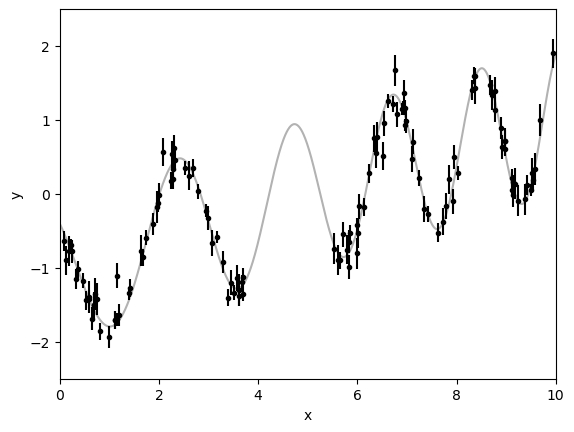

In [2]:
import numpy as np
import matplotlib.pyplot as plt
np.random.seed(42)

t = np.sort(np.append(
    np.random.uniform(0, 3.8, 57),
    np.random.uniform(5.5, 10, 68),
))  # The input coordinates must be sorted
yerr = np.random.uniform(0.08, 0.22, len(t))
y = 0.2 * (t-5) + np.sin(3*t + 0.1*(t-5)**2) + yerr * np.random.randn(len(t))

true_t = np.linspace(0, 10, 5000)
true_y = 0.2 * (true_t-5) + np.sin(3*true_t + 0.1*(true_t-5)**2)

plt.plot(true_t, true_y, "k", lw=1.5, alpha=0.3)
plt.errorbar(t, y, yerr=yerr, fmt=".k", capsize=0)
plt.xlabel("x")
plt.ylabel("y")
plt.xlim(0, 10)
plt.ylim(-2.5, 2.5)

In [3]:
import celerite
from celerite import terms

# A non-periodic component
Q = 1.0 / np.sqrt(2.0)
w0 = 3.0
S0 = np.var(y) / (w0 * Q)
bounds = dict(log_S0=(-15, 15), log_Q=(-15, 15), log_omega0=(-15, 15))
kernel = terms.SHOTerm(log_S0=np.log(S0), log_Q=np.log(Q), log_omega0=np.log(w0),
                       bounds=bounds)
kernel.freeze_parameter("log_Q")  # We don't want to fit for "Q" in this term

# A periodic component
Q = 1.0
w0 = 3.0
S0 = np.var(y) / (w0 * Q)
kernel += terms.SHOTerm(log_S0=np.log(S0), log_Q=np.log(Q), log_omega0=np.log(w0),
                        bounds=bounds)

In [4]:
gp = celerite.GP(kernel, mean=np.mean(y))
gp.compute(t, yerr)  # You always need to call compute once.
print("Initial log likelihood: {0}".format(gp.log_likelihood(y)))

Initial log likelihood: -6.756596382629411


In [5]:
from scipy.optimize import minimize

def neg_log_like(params, y, gp):
    gp.set_parameter_vector(params)
    return -gp.log_likelihood(y)

initial_params = gp.get_parameter_vector()
bounds = gp.get_parameter_bounds()

r = minimize(neg_log_like, initial_params, method="L-BFGS-B", bounds=bounds, args=(y, gp))
gp.set_parameter_vector(r.x)
print(r)

  message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
  success: True
   status: 0
      fun: -16.563201712403497
        x: [ 3.278e+00 -2.024e+00 -4.161e+00  2.342e+00  1.136e+00]
      nit: 30
      jac: [ 5.684e-06  1.705e-05 -6.821e-05  0.000e+00 -6.480e-04]
     nfev: 306
     njev: 51
 hess_inv: <5x5 LbfgsInvHessProduct with dtype=float64>


In [6]:
x = np.linspace(0, 10, 5000)
pred_mean, pred_var = gp.predict(y, x, return_var=True)
pred_std = np.sqrt(pred_var)

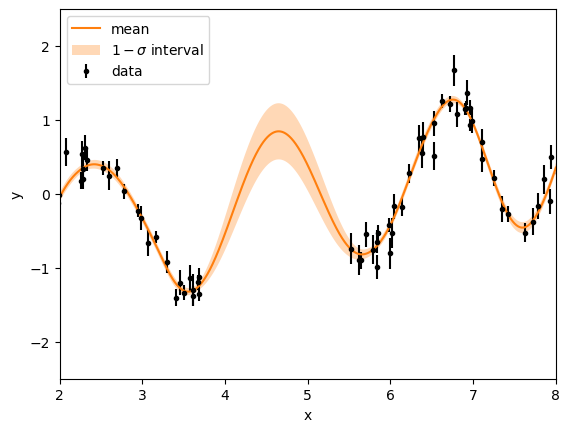

In [13]:
color = "#ff7f0e"
# plt.plot(true_t, true_y, "k", lw=1.5, alpha=0.3)
plt.errorbar(t, y, yerr=yerr, fmt=".k", capsize=0, label='data')
plt.plot(x, pred_mean, color=color, label='mean')
plt.fill_between(x, pred_mean+pred_std, pred_mean-pred_std, color=color, alpha=0.3,
                 edgecolor="none", label=r'$1-\sigma$ interval')
plt.xlabel("x")
plt.ylabel("y")
plt.xlim(2, 8)
plt.ylim(-2.5, 2.5)
plt.legend()
plt.savefig('GP_example.png')